# Install and import library

In [133]:
!pip install fredapi

In [134]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from fredapi import Fred

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import metrics

# Initialize FRED API
fred = Fred(api_key='cd43db9317c6e9c88ea4548a7742d844')

# Load Dataset, explore and preprocess the data

In [135]:
# Fetch macroeconomic data
# Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
cpi = fred.get_series('CPIAUCSL')

# Producer Price Index by Commodity: All Commodities
ppi = fred.get_series('PPIACO')

# Unemployment Rate of United State
unrate = fred.get_series('UNRATE')

# GDP of the United States
gdp = fred.get_series('GDP')

# Prepare the economic data as a DataFrame
economic_data = pd.DataFrame({
    'CPI': cpi,
    'PPI': ppi,
    'Unemployment Rate': unrate,
    'GDP': gdp
}).reset_index().rename(columns={'index': 'Date'})

economic_data.tail(8)

,Date,CPI,PPI,Unemployment Rate,GDP
1334,2024-03-01,312.230,255.095,3.8,NaN
1335,2024-04-01,313.207,256.978,3.9,29016.714
1336,2024-05-01,313.225,255.313,4.0,NaN
1337,2024-06-01,313.049,255.914,4.1,NaN
1338,2024-07-01,313.534,257.326,4.3,29354.321
1339,2024-08-01,314.121,255.394,4.2,NaN
1340,2024-09-01,314.686,252.737,4.1,NaN
1341,2024-10-01,315.454,253.452,4.1,NaN


In [136]:
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1342 non-null   datetime64[ns]
 1   CPI                934 non-null    float64       
 2   PPI                1342 non-null   float64       
 3   Unemployment Rate  922 non-null    float64       
 4   GDP                311 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 52.5 KB


In [137]:
# Ensure economic_data is forward-filled to cover daily granularity
economic_data = economic_data.set_index('Date').asfreq('D').fillna(method='ffill').reset_index()

economic_data.tail(8)

<ipython-input-137-cf05493f4b1c>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  economic_data = economic_data.set_index('Date').asfreq('D').fillna(method='ffill').reset_index()


,Date,CPI,PPI,Unemployment Rate,GDP
40809,2024-09-24,314.686,252.737,4.1,29354.321
40810,2024-09-25,314.686,252.737,4.1,29354.321
40811,2024-09-26,314.686,252.737,4.1,29354.321
40812,2024-09-27,314.686,252.737,4.1,29354.321
40813,2024-09-28,314.686,252.737,4.1,29354.321
40814,2024-09-29,314.686,252.737,4.1,29354.321
40815,2024-09-30,314.686,252.737,4.1,29354.321
40816,2024-10-01,315.454,253.452,4.1,29354.321


In [138]:
economic_data['Date'] = pd.to_datetime(economic_data['Date'])

# Load Tesla stock data
data = '/content/TSLA.csv'
df = pd.read_csv(data, parse_dates=True, index_col='Date')

# Merge stock data with adjusted macroeconomic data
df = df.merge(economic_data, on='Date', how='left')

# Save the merged DataFrame to a CSV file
output_path = '/content/TSLA_with_macro_data.csv'
df.to_csv(output_path)

print(f"File saved to {output_path}")

File saved to /content/TSLA_with_macro_data.csv


In [139]:
data_new = '/content/TSLA_with_macro_data.csv'
df = pd.read_csv(data_new, parse_dates=True, index_col='Date')

In [140]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,CPI,PPI,Unemployment Rate,GDP
Date,,,,,,,,,,,
2010-06-29,0,3.800,5.000,3.508,4.778,4.778,93831500,217.199,183.5,9.4,14980.193
2010-06-30,1,5.158,6.084,4.660,4.766,4.766,85935500,217.199,183.5,9.4,14980.193
2010-07-01,2,5.000,5.184,4.054,4.392,4.392,41094000,217.605,184.1,9.4,15141.607
2010-07-02,3,4.600,4.620,3.742,3.840,3.840,25699000,217.605,184.1,9.4,15141.607
2010-07-06,4,4.000,4.000,3.166,3.222,3.222,34334500,217.605,184.1,9.4,15141.607


In [141]:
# Checking for missing values
df.isnull().sum()

,0
Unnamed: 0,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
CPI,0
PPI,0
Unemployment Rate,0


In [142]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2956 non-null   float64
 1   High               2956 non-null   float64
 2   Low                2956 non-null   float64
 3   Close              2956 non-null   float64
 4   Adj Close          2956 non-null   float64
 5   Volume             2956 non-null   int64  
 6   CPI                2956 non-null   float64
 7   PPI                2956 non-null   float64
 8   Unemployment Rate  2956 non-null   float64
 9   GDP                2956 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 254.0 KB


In [144]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2956.0,1.386913e+02,2.500448e+02,3.228,1.962700e+01,4.665700e+01,6.805700e+01,1.234410e+03
High,2956.0,1.417716e+02,2.558632e+02,3.326,2.040200e+01,4.748700e+01,6.935750e+01,1.243490e+03
Low,2956.0,1.354260e+02,2.437742e+02,2.996,1.912750e+01,4.582000e+01,6.691150e+01,1.217000e+03
Close,2956.0,1.387622e+02,2.501231e+02,3.160,1.961500e+01,4.654500e+01,6.810400e+01,1.229910e+03
Adj Close,2956.0,1.387622e+02,2.501231e+02,3.160,1.961500e+01,4.654500e+01,6.810400e+01,1.229910e+03
Volume,2956.0,3.131449e+07,2.798383e+07,592500.000,1.310288e+07,2.488680e+07,3.973875e+07,3.046940e+08
CPI,2956.0,2.436144e+02,1.519387e+01,217.199,2.329000e+02,2.395570e+02,2.552130e+02,2.875530e+02
PPI,2956.0,2.008611e+02,1.349069e+01,181.300,1.930000e+02,2.003000e+02,2.040000e+02,2.600140e+02
Unemployment Rate,2956.0,6.113532e+00,2.150087e+00,3.500,4.300000e+00,5.600000e+00,7.800000e+00,1.480000e+01
GDP,2956.0,1.906870e+04,2.627891e+03,14980.193,1.672869e+04,1.871170e+04,2.111160e+04,2.521549e+04


# Visualize the data

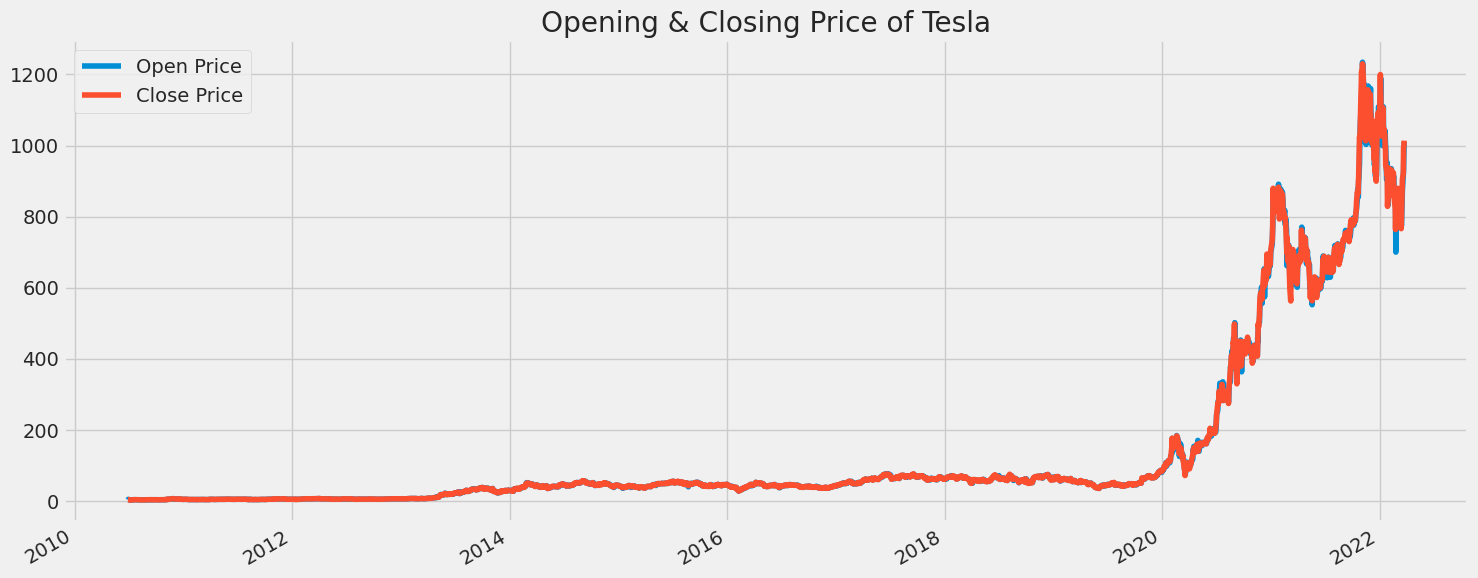

In [145]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

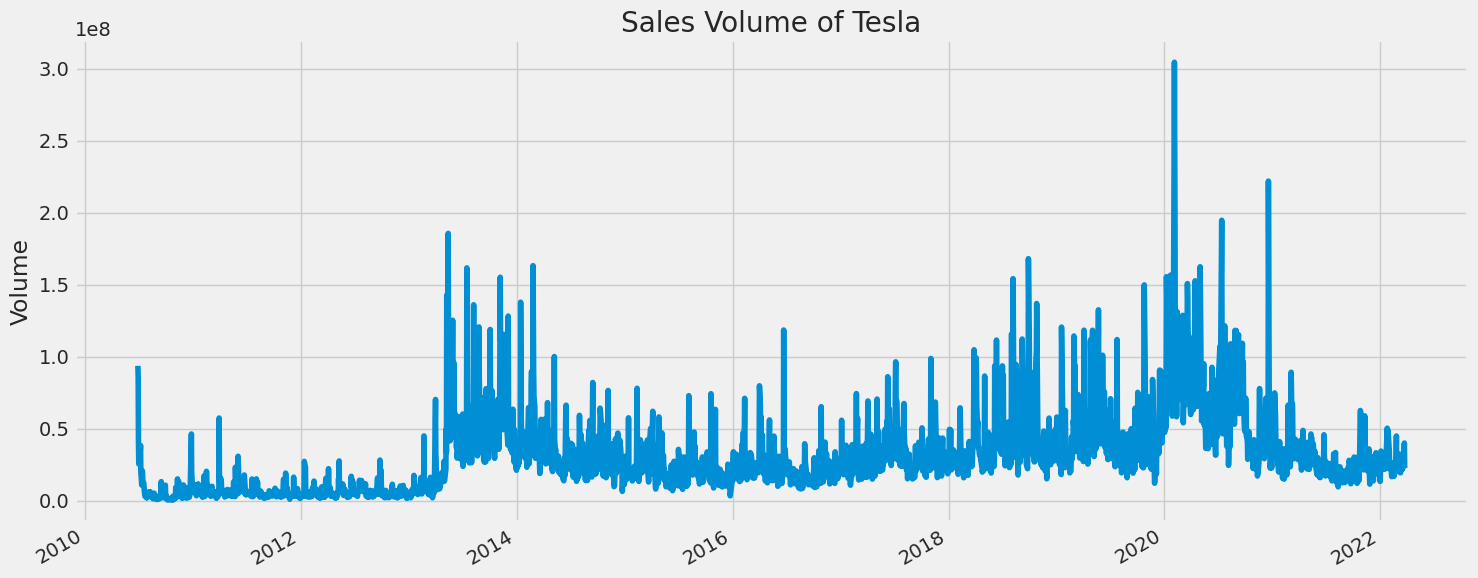

In [146]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

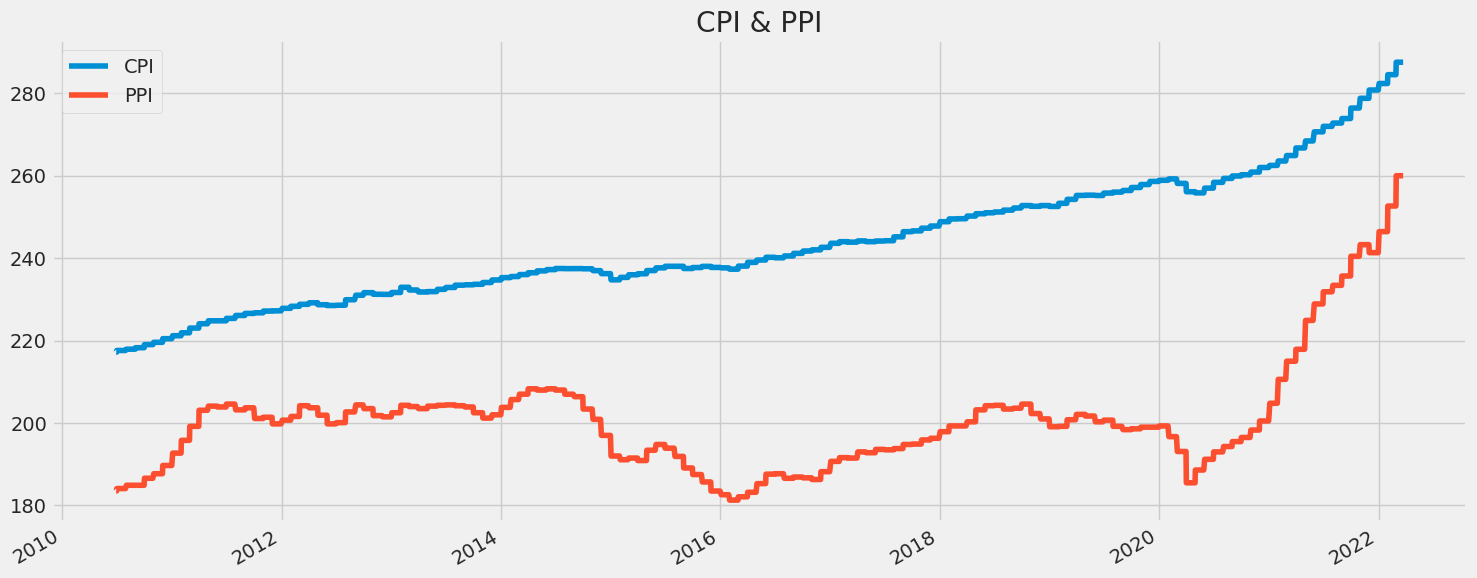

In [147]:
plt.figure(figsize=(15, 6))
df['CPI'].plot()
df['PPI'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("CPI & PPI")
plt.legend(['CPI', 'PPI'])
plt.tight_layout()
plt.show()

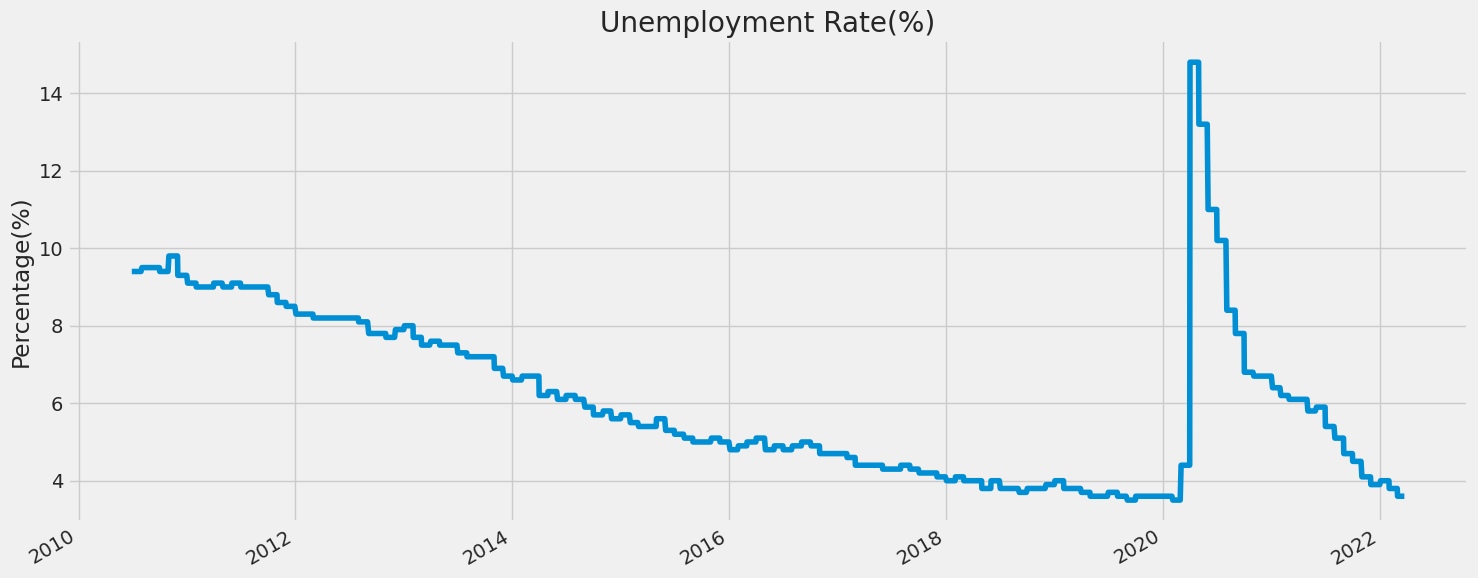

In [148]:
plt.figure(figsize=(15, 6))
df['Unemployment Rate'].plot()
plt.ylabel('Percentage(%)')
plt.xlabel(None)
plt.title("Unemployment Rate(%)")
plt.tight_layout()
plt.show()

High                 0.999726
Low                  0.999617
Close                0.999247
Adj Close            0.999247
CPI                  0.790250
PPI                  0.750312
GDP                  0.749770
Volume               0.089750
Unemployment Rate   -0.172171
Name: Open, dtype: float64


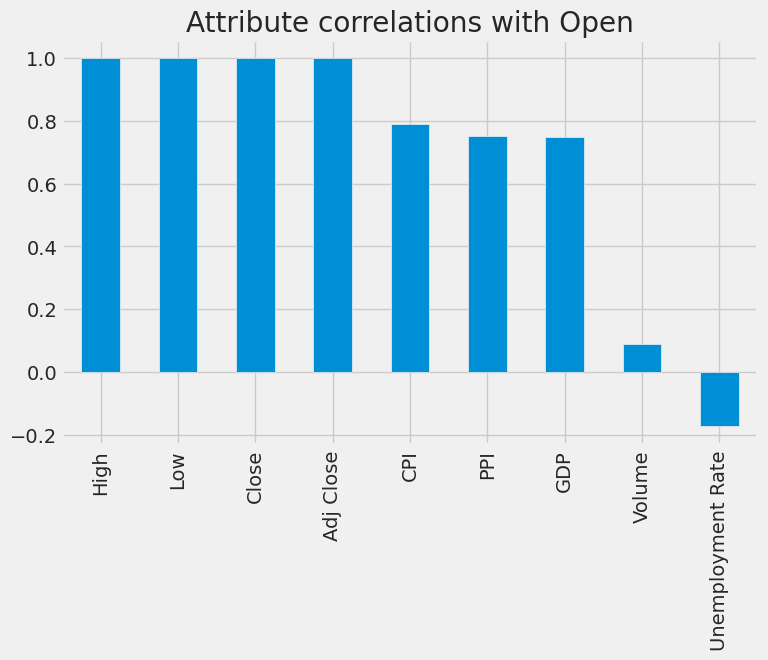

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Exclude 'Open' from the correlation matrix
correlation_matrix_no_open = correlation_matrix.drop('Open', axis=0).drop('Open', axis=1)

# Extract correlations with 'Open' (from the original matrix)
open_correlations = correlation_matrix['Open']

# Sort correlations in descending order (excluding 'Open' itself)
open_correlations = open_correlations.drop('Open').sort_values(ascending=False)

# Print the correlations with 'Open' (excluding 'Open' itself)
print(open_correlations)

# Plot attribute correlations with Rings graph
plt.figure(figsize=(8,5))
correlation_matrix["Open"].drop("Open").sort_values(ascending=False).plot(kind='bar')
plt.title("Attribute correlations with Open")
plt.show()

#  Prepare data to train model

In [150]:
X = df.drop('Open', axis=1)
y = df['Open']

X = X.values  # Convert to NumPy array

In [151]:
# Create the training and test datasets:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.25)

In [152]:
# Standardize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Evaluate and compare model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 93565.6875 - val_loss: 76443.9062
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86608.2578 - val_loss: 70881.3359
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75838.8125 - val_loss: 55131.8555
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51478.9180 - val_loss: 35455.3633
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34811.7148 - val_loss: 24618.3516
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25977.5391 - val_loss: 17522.1562
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17627.3750 - val_loss: 11219.3594
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10684.5791 - val_loss: 6054.8438
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5304.9731 - val_loss: 2947.6567
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2585.0220 - val_loss: 1534.6079
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1314.3301 - val_loss: 973.2093
Epoc

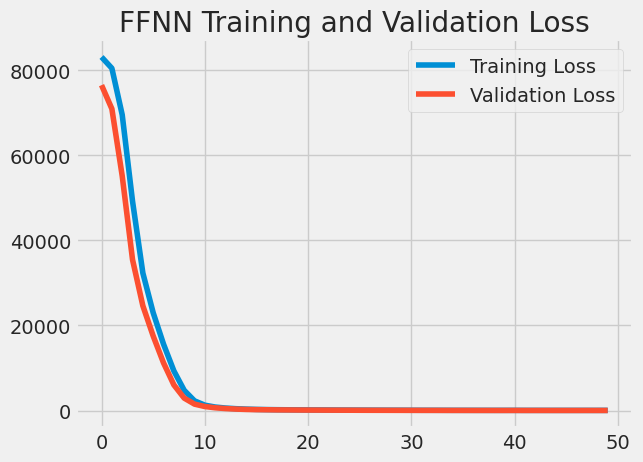

In [153]:
# Define FNN model
fnn_model = Sequential()
fnn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
fnn_model.add(Dense(32, activation='relu'))  # Hidden layer
fnn_model.add(Dense(1))  # Output layer (for regression)

# Compile the model
fnn_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
historyfnn = fnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(historyfnn.history['loss'], label='Training Loss')
plt.plot(historyfnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('FFNN Training and Validation Loss')
plt.show()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 1562.3361 - val_loss: 392997.9062
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1356.8650 - val_loss: 390389.0312
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1153.2922 - val_loss: 387972.0312
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1035.8778 - val_loss: 385666.5938
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 988.5211 - val_loss: 383500.3750
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 900.8740 - val_loss: 381464.1562
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 844.1155 - val_loss: 379547.3125
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 762.2559 - val_loss: 377793.1875
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 695.1669 - val_loss: 376502.7500
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 625.1639 - val_loss: 375437.0938
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 529.4869 - val_loss: 373533.68

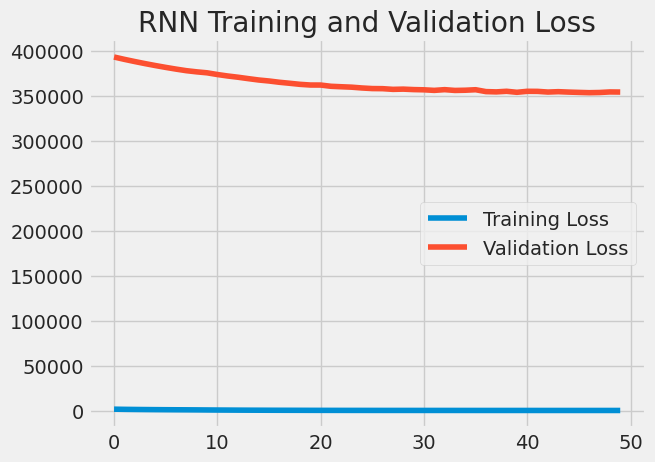

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for RNN
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, return_sequences = True,
                        input_shape = (X_train.shape[1], 1)))

rnn_model.add(SimpleRNN(32, return_sequences = False))
rnn_model.add(Dense(1))  # Output layer (for regression)

# Compile the model
rnn_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
historyrnn = rnn_model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Plot training history
plt.plot(historyrnn.history['loss'], label='Training Loss')
plt.plot(historyrnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('RNN Training and Validation Loss')
plt.show()

In [155]:
def evaluate_model(estimator, X_train, y_train, cv=10, verbose=True):
    """Print and return cross validation of model to see if it overfitting
    """
    # Define scoring metrics
    scoring = ["neg_mean_squared_error"]
    scores = cross_validate(estimator, X_train, y_train, return_train_score=True,
                            cv=cv, scoring=scoring)

    # Calculate root mean squared error (RMSE) for validation and training sets
    train_rmse_mean = -scores['train_neg_mean_squared_error'].mean()
    val_rmse_mean = -scores['test_neg_mean_squared_error'].mean()

    # Organize results in a dictionary
    result = {
        "Train RMSE": train_rmse_mean,
        "Val RMSE": val_rmse_mean,
    }

    # Print results if verbose is True
    if verbose:
        print(f"train_MSE_mean: {train_rmse_mean}")
        print(f"val_MSE_mean: {val_rmse_mean}")


    return result

In [156]:
# Define a list of regression models to evaluate
models = [LinearRegression(),
          RandomForestRegressor(),
          DecisionTreeRegressor(),
          SVR()]

model_names = ["Linear Regression", "Random Forest", "Decision Tree",
               "Support Vector Machine", "Feed Forward Neural Network",
               "Reccurent Neural Network"]

In [157]:
# Lists to store MSE
mse = []

for model in range(4):
    print(f"Model {model+1} of {4}")
    print(f"...running {model_names[model]}")

    rg_scores = evaluate_model(models[model], X_train, y_train)
    mse.append(rg_scores["Val RMSE"])

# Store the validation loss of fnn
mse.append(historyfnn.history['val_loss'][-1])

# Store the validation loss of rnn
mse.append(historyrnn.history['val_loss'][-1])

Model 1 of 4
...running Linear Regression
train_MSE_mean: 15.339478064497408
val_MSE_mean: 16.399396456998993
Model 2 of 4
...running Random Forest
train_MSE_mean: 5.912755535596556
val_MSE_mean: 44.669903019094725
Model 3 of 4
...running Decision Tree
train_MSE_mean: -0.0
val_MSE_mean: 66.39799242722867
Model 4 of 4
...running Support Vector Machine
train_MSE_mean: 30060.804839186767
val_MSE_mean: 30323.47575706487


In [158]:
# See the result and compare it
df_result = pd.DataFrame({"Model": model_names,
                          "MSE": mse})
df_result

,Model,MSE
0,Linear Regression,16.399396
1,Random Forest,44.669903
2,Decision Tree,66.397992
3,Support Vector Machine,30323.475757
4,Feed Forward Neural Network,45.272999
5,Reccurent Neural Network,354046.625000


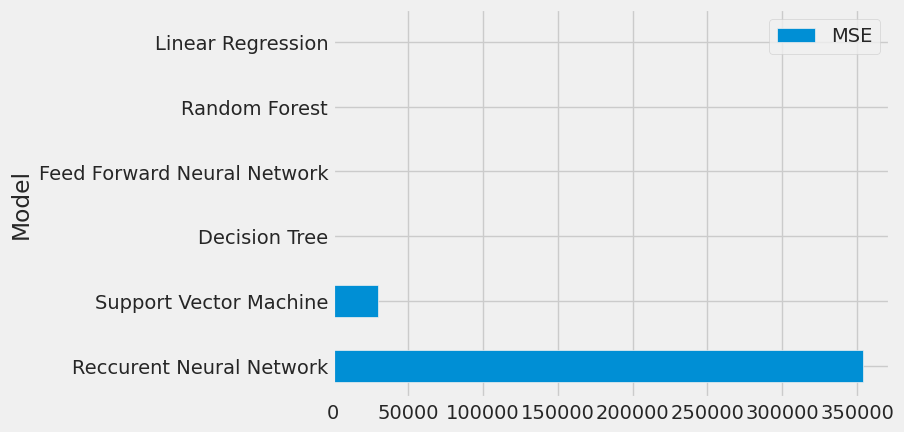

In [159]:
df_result.sort_values(by="MSE", ascending=False).plot.barh("Model", "MSE");

# Handle Overfitting

In [160]:
economic_data['Date'] = pd.to_datetime(economic_data['Date'])

# Load Tesla stock data
data = '/content/AAPL.csv'
df = pd.read_csv(data, parse_dates=True, index_col='Date')

# Merge stock data with adjusted macroeconomic data
df = df.merge(economic_data, on='Date', how='left')

# Save the merged DataFrame to a CSV file
output_path = '/content/AAPL_with_macro_data.csv'
df.to_csv(output_path)

print(f"File saved to {output_path}")

File saved to /content/AAPL_with_macro_data.csv


In [161]:
data_new = '/content/AAPL_with_macro_data.csv'
df = pd.read_csv(data_new, parse_dates=True, index_col='Date')

In [162]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

In [163]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,CPI,PPI,Unemployment Rate,GDP
Date,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600,86.4,93.8,7.2,2985.557
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800,86.4,93.8,7.2,2985.557
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000,86.4,93.8,7.2,2985.557
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600,86.4,93.8,7.2,2985.557
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600,86.4,93.8,7.2,2985.557


In [164]:
X = df.drop('Open', axis=1)
y = df['Open']

X = X.values  # Convert to NumPy array

In [165]:
# Create the training and test datasets:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.25)

In [166]:
# Standardize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [167]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 933.7229 - val_loss: 139.4648
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 67.0277 - val_loss: 3.6754
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3361 - val_loss: 0.5666
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4838 - val_loss: 0.2481
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2464 - val_loss: 0.2022
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1996 - val_loss: 0.1890
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2141 - val_loss: 0.1973
Epoch 8/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1814 - val_loss: 0.1693
Epoch 9/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2245 - val_loss: 0.1698
Epoch 10/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2142 - val_loss: 0.1670
Epoch 11/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2118 - val_loss: 0.1526
Epoch 12/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - los

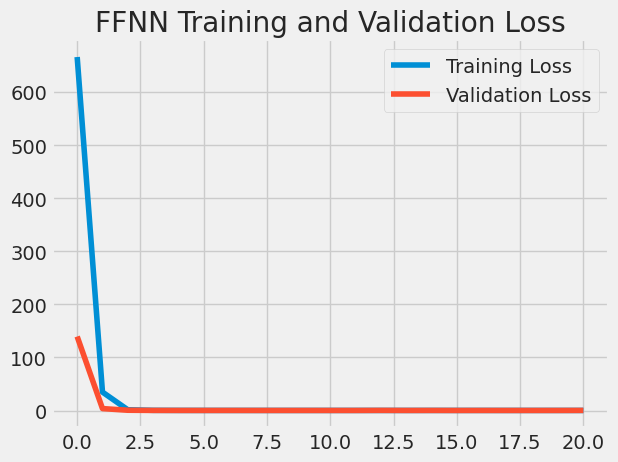

In [168]:
# Define FNN model
fnn_model = Sequential()
fnn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
fnn_model.add(Dense(32, activation='relu'))  # Hidden layer
fnn_model.add(Dense(1))  # Output layer (for regression)

# Compile the model
# Apply earlystopping to reduce overfitting or underfitting
fnn_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
historyfnn = fnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                           callbacks=[early_stopping])

# Plot training history
plt.plot(historyfnn.history['loss'], label='Training Loss')
plt.plot(historyfnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('FFNN Training and Validation Loss')
plt.show()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 17.1557 - val_loss: 4211.3970
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6320 - val_loss: 3849.4888
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6542 - val_loss: 3653.3096
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9400 - val_loss: 3523.3313
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7319 - val_loss: 3443.5652


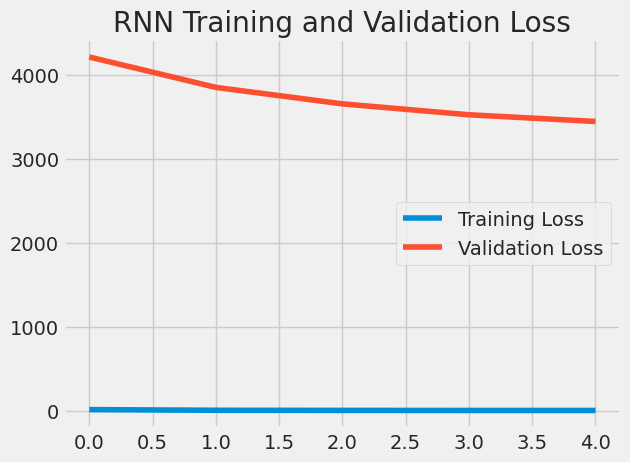

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for RNN
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define RNN model
# Regularization: add penalties to the loss function to discourage overly complex models.
# Here i use L2 Regularization: Adds penalties proportional to the squared values of the weights (smooth model).
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, return_sequences = True,
                        input_shape = (X_train.shape[1], 1),
                        kernel_regularizer=l2(0.01)))
rnn_model.add(SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(0.01)))
rnn_model.add(Dense(1, kernel_regularizer=l2(0.01)))  # Output layer (for regression)

# Compile the model
rnn_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
# Apply earlystopping to reduce overfitting
historyrnn = rnn_model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2,
                           callbacks=[early_stopping])

# Plot training history
plt.plot(historyrnn.history['loss'], label='Training Loss')
plt.plot(historyrnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('RNN Training and Validation Loss')
plt.show()

In [170]:
def evaluate_model(estimator, X_train, y_train, cv=10, verbose=True):
    """Print and return cross validation of model to see if it overfitting
    """
    # Define scoring metrics
    scoring = ["neg_mean_squared_error"]
    scores = cross_validate(estimator, X_train, y_train, return_train_score=True,
                            cv=cv, scoring=scoring)

    # Calculate root mean squared error (RMSE) for validation and training sets
    train_rmse_mean = -scores['train_neg_mean_squared_error'].mean()
    val_rmse_mean = -scores['test_neg_mean_squared_error'].mean()

    # Organize results in a dictionary
    result = {
        "Train RMSE": train_rmse_mean,
        "Val RMSE": val_rmse_mean,
    }

    # Print results if verbose is True
    if verbose:
        print(f"train_MSE_mean: {train_rmse_mean}")
        print(f"val_MSE_mean: {val_rmse_mean}")


    return result

In [171]:
# Define a list of regression models to evaluate
models = [LinearRegression(),
          # Hyperparameter tuning
          # Limit Tree Depth (max_depth)
          # Increase Minimum Samples Per Split/Leaf
          # Increase the Number of Trees (n_estimators)
          RandomForestRegressor(max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                n_estimators=500),
          DecisionTreeRegressor(max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf=5,),
          SVR()]

model_names = ["Linear Regression", "Random Forest", "Decision Tree",
               "Support Vector Machine", "Feed Forward Neural Network",
               "Reccurent Neural Network"]

In [172]:
# Lists to store MSE
mse = []

for model in range(4):
    print(f"Model {model+1} of {4}")
    print(f"...running {model_names[model]}")

    rg_scores = evaluate_model(models[model], X_train, y_train)
    mse.append(rg_scores["Val RMSE"])

# Store the validation loss of fnn
mse.append(historyfnn.history['val_loss'][-1])

# Store the validation loss of rnn
mse.append(historyrnn.history['val_loss'][-1])

Model 1 of 4
...running Linear Regression
train_MSE_mean: 0.04674319906949603
val_MSE_mean: 0.04792334735100841
Model 2 of 4
...running Random Forest
train_MSE_mean: 0.0450253334814673
val_MSE_mean: 0.11662118205895566
Model 3 of 4
...running Decision Tree
train_MSE_mean: 0.0518774465060576
val_MSE_mean: 0.15889251734412496
Model 4 of 4
...running Support Vector Machine
train_MSE_mean: 6.331745363668953
val_MSE_mean: 6.430350025288765


In [173]:
# See the result and compare it
df_result = pd.DataFrame({"Model": model_names,
                          "MSE": mse})
df_result

,Model,MSE
0,Linear Regression,0.047923
1,Random Forest,0.116621
2,Decision Tree,0.158893
3,Support Vector Machine,6.430350
4,Feed Forward Neural Network,0.236778
5,Reccurent Neural Network,3443.565186


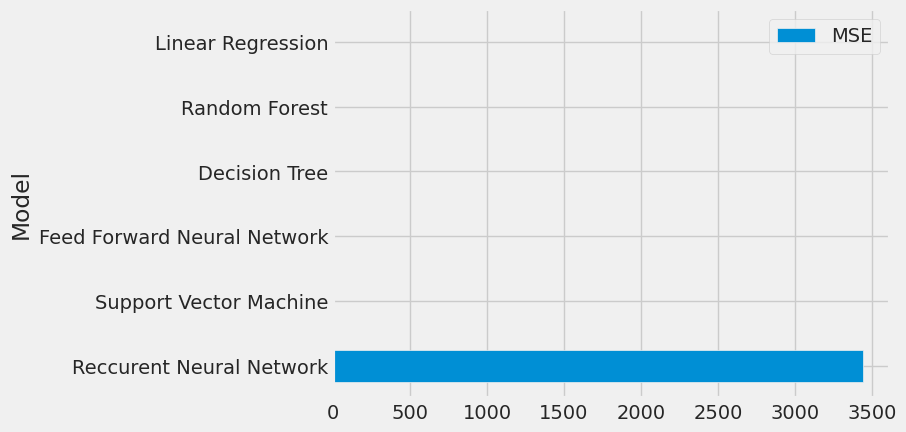

In [174]:
df_result.sort_values(by="MSE", ascending=False).plot.barh("Model", "MSE");

# Visualize Predictions with The Data for the best model (Linear Regression)

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def prepare_data(file_path):
    """
    Prepares the data for training and testing.
    Args:
        file_path: Path to the CSV file.
    Returns:
        Scaled training and testing datasets, scaler, and original dataset.
    """
    # Load the dataset
    dataset = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    dataset = dataset[['Open']]  # Use 'Open' column for prediction

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset.values)

    # Split into train and test
    train_size = int(len(scaled_data) * 0.75)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    # Prepare sequences for training and testing
    X_train, y_train = [], []
    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    X_test, y_test = [], []
    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, 0])
        y_test.append(test_data[i, 0])

    return (
        np.array(X_train), np.array(y_train),
        np.array(X_test), np.array(y_test),
        scaler, dataset, train_size
    )

def plot_results(train_data, test_data, predictions, title):
    """
    Plots the training data, testing data, and predictions.
    Args:
        train_data: DataFrame containing training data.
        test_data: DataFrame containing testing data.
        predictions: Predicted values.
        title: Title for the plot.
    """
    plt.figure(figsize=(16, 6))
    plt.title(title, fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Open Price', fontsize=18)

    plt.plot(train_data.index, train_data['Open'], linewidth=3, label='Train')
    plt.plot(test_data.index, test_data['Open'], linewidth=3, label='Test')
    plt.plot(test_data.index, test_data['Predictions'], linewidth=3, label='Predictions')

    plt.legend()
    plt.show()

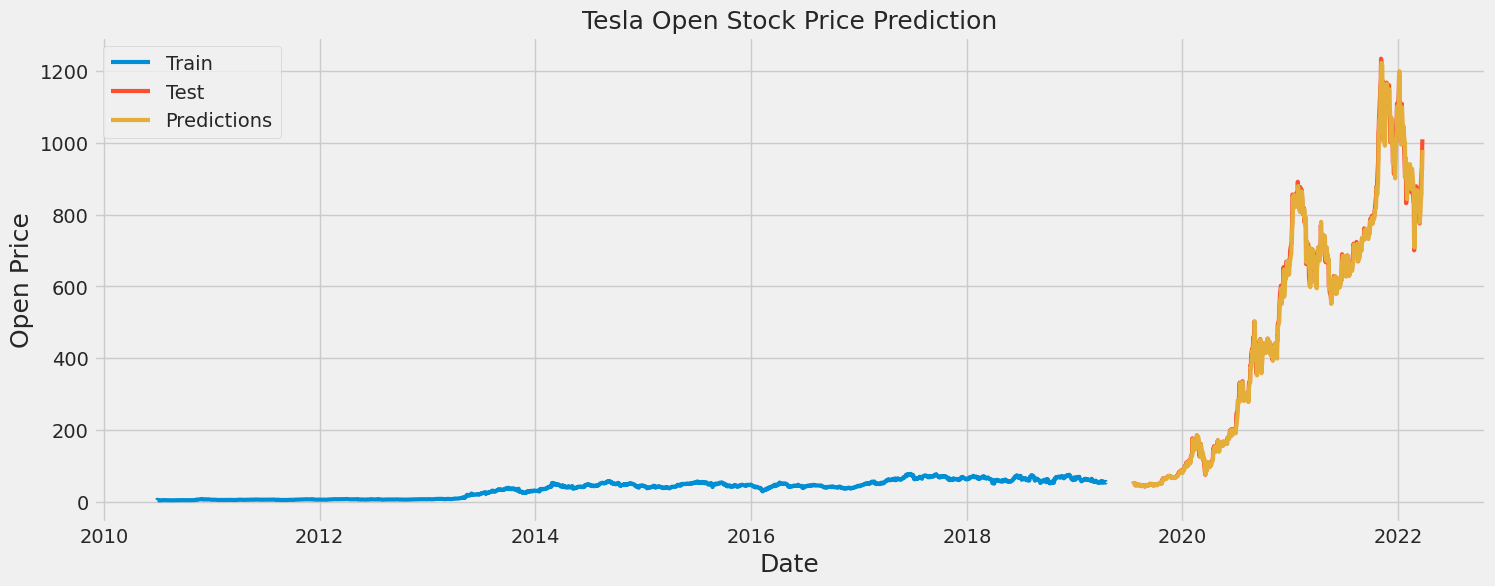

Tesla Mean Squared Error: 643.1301374138529


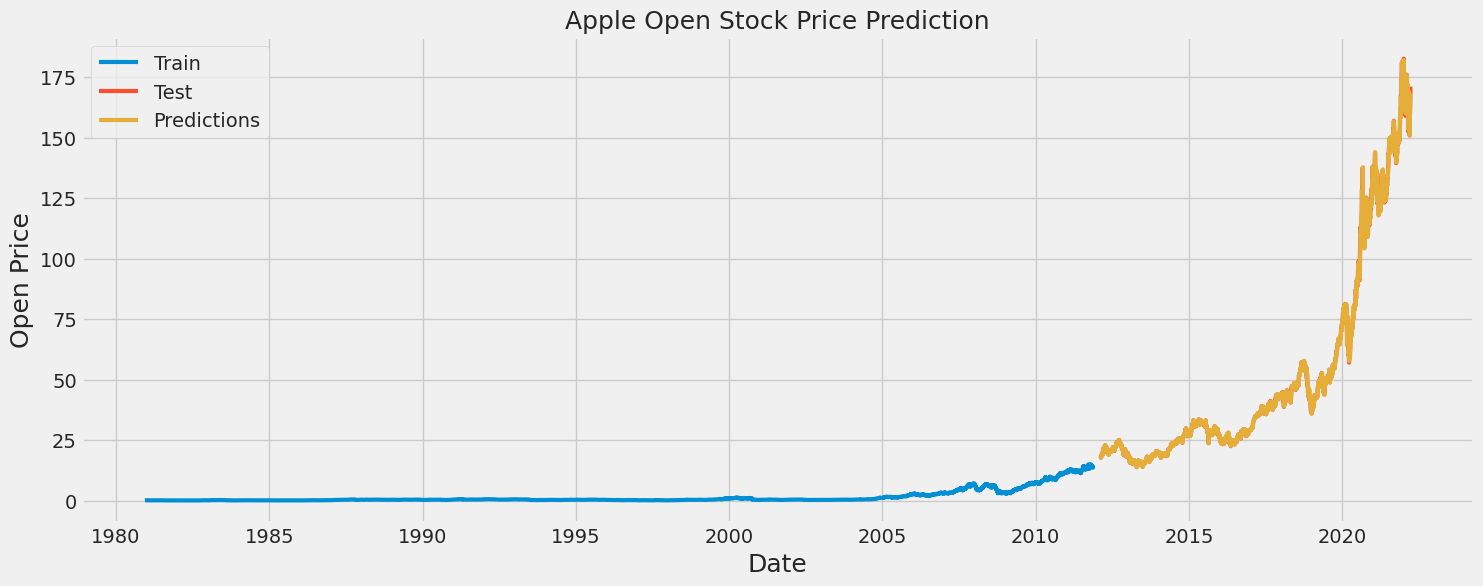

Apple Mean Squared Error: 1.8930502877478739


In [176]:
# File paths for Tesla and Apple datasets
tesla_file = '/content/TSLA_with_macro_data.csv'
apple_file = '/content/AAPL_with_macro_data.csv'

for stock_file, stock_name in zip([tesla_file, apple_file], ['Tesla', 'Apple']):
    # Prepare data
    X_train, y_train, X_test, y_test, scaler, dataset, train_size = prepare_data(stock_file)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    predictions = model.predict(X_test)

    # Inverse transform
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Split dataset into train and test for plotting
    train_data = dataset[:train_size]
    test_data = dataset[train_size:]
    test_data = test_data.iloc[60:]  # Align with predictions
    test_data['Predictions'] = predictions

    # Plot results
    plot_results(train_data, test_data, predictions, f'{stock_name} Open Stock Price Prediction')

    # Evaluate model
    mse = mean_squared_error(y_test, predictions)
    print(f"{stock_name} Mean Squared Error: {mse}")
